# **Predictive Modeling for Clinical Decision Support: Reducing Diagnostic Error**

In [8]:
## Load Libraries and Dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import statsmodels.api as sm

In [9]:
# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Original target: 0 = malignant, 1 = benign
df['diagnosis'] = data.target

# Recode for intuitive interpretation: 1 = malignant, 0 = benign
df['malignant'] = df['diagnosis'].apply(lambda x: 0 if x == 1 else 1)

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,1


In [10]:
# Descriptive Statistics
df[['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness']].describe()

,mean radius,mean texture,mean perimeter,mean smoothness
count,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,0.096360
std,3.524049,4.301036,24.298981,0.014064
min,6.981000,9.710000,43.790000,0.052630
25%,11.700000,16.170000,75.170000,0.086370
50%,13.370000,18.840000,86.240000,0.095870
75%,15.780000,21.800000,104.100000,0.105300
max,28.110000,39.280000,188.500000,0.163400


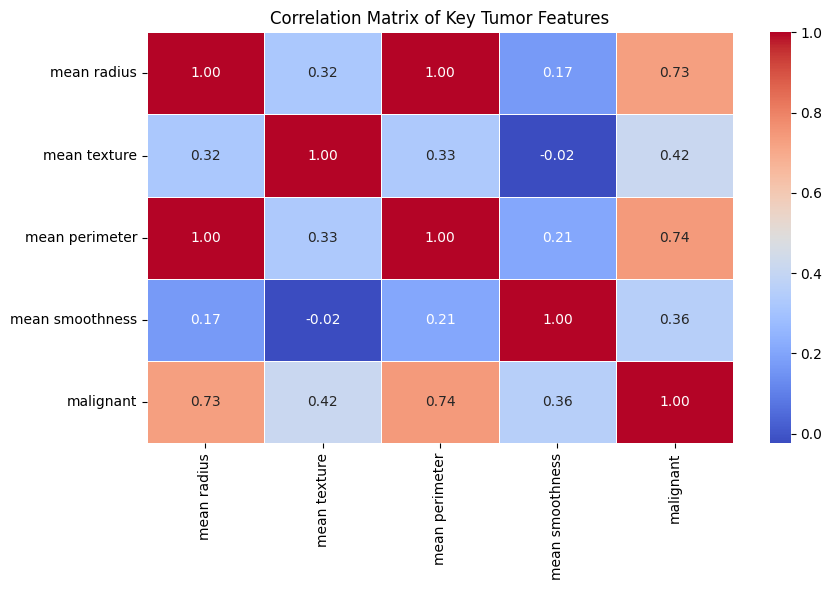

In [11]:
# Correlation Analysis (Clean & Interpretable)
plt.figure(figsize=(9, 6))
sns.heatmap(
    df[['mean radius', 'mean texture', 'mean perimeter',
        'mean smoothness', 'malignant']].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Matrix of Key Tumor Features")
plt.tight_layout()
plt.show()

In [12]:
# Logistic Regression (Interpretability First)
# Feature selection based on clinical relevance
X = df[['mean radius', 'mean texture', 'mean smoothness']]
X = sm.add_constant(X)
y = df['malignant']

model = sm.Logit(y, X)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.164578
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              malignant   No. Observations:                  569
Model:                          Logit   Df Residuals:                      565
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Jan 2026   Pseudo R-squ.:                  0.7508
Time:                        07:31:47   Log-Likelihood:                -93.645
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                5.954e-122
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -42.0194      4.459     -9.423      0.000     -50.760     -33.279
mean radius         1.3970      0.154      9.069      0.000       1.095       1.699
mean texture        0.3806      0.057      6.663      0.000       0.269       0.492
mean smoothness   144.6742     19.047      7.596      0.000     107.343     182.005
===================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [15]:
# Odds Ratios (Clinical Interpretation)
odds_ratios = np.exp(result.params)
odds_ratios

,0
const,5.639013e-19
mean radius,4.043022e+00
mean texture,1.463102e+00
mean smoothness,6.779825e+62


In [16]:
# Predicted probabilities & Classification
df['predicted_prob'] = result.predict(X)

# Default classification threshold = 0.5
df['predicted_class'] = (df['predicted_prob'] >= 0.5).astype(int)

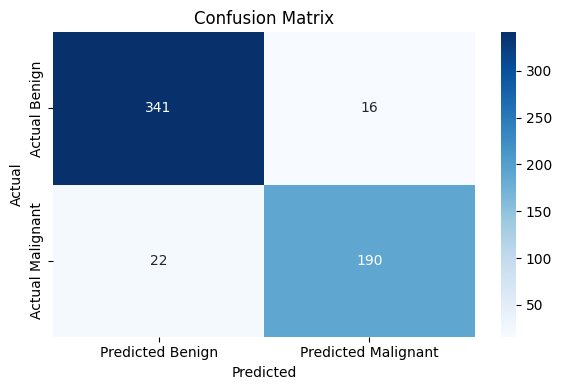

In [17]:
# Confusion Matrix (Clinical Risk Trade-offs)
cm = confusion_matrix(y, df['predicted_class'])

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Benign", "Predicted Malignant"],
    yticklabels=["Actual Benign", "Actual Malignant"]
)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [18]:
# Precision vs Recall (Clinical Framing)
print(classification_report(
    y,
    df['predicted_class'],
    target_names=["Benign", "Malignant"]
))

              precision    recall  f1-score   support

      Benign       0.94      0.96      0.95       357
   Malignant       0.92      0.90      0.91       212

    accuracy                           0.93       569
   macro avg       0.93      0.93      0.93       569
weighted avg       0.93      0.93      0.93       569



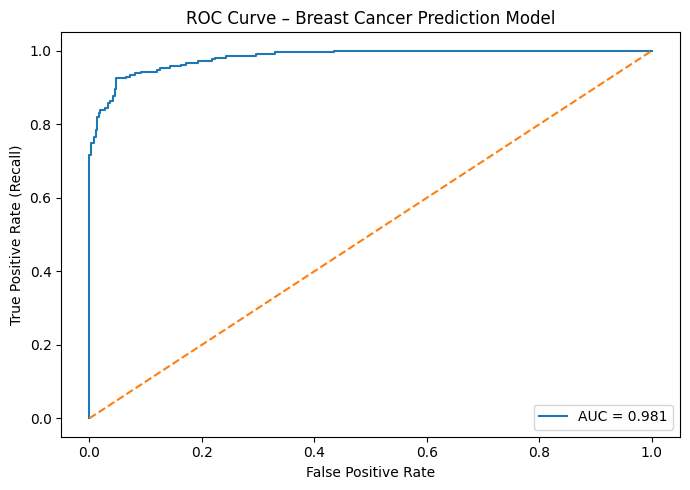

np.float64(0.9811056498070927)

In [19]:
# ROC Curve & AUC (Overall Model Performance)
auc = roc_auc_score(y, df['predicted_prob'])

fpr, tpr, thresholds = roc_curve(y, df['predicted_prob'])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Breast Cancer Prediction Model")
plt.legend()
plt.tight_layout()
plt.show()

auc

In [20]:
# Penalized logistic regression to mitigate quasi-separation
penalized_model = sm.Logit(y, X)
penalized_result = penalized_model.fit_regularized(method='l1', alpha=0.1)

penalized_result.params

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19368162257575816
            Iterations: 80
            Function evaluations: 82
            Gradient evaluations: 80


,0
const,-34.681525
mean radius,1.212657
mean texture,0.316075
mean smoothness,109.807818
